## Análise de Dados de Consultas Entre Idades e Sexo

[link imagem]

Esse projeto explora dados publicos para verificar se homens vão ao médico mais tarde que mulheres.

**Plano** <br>
1) encontrar a quantidade de vidas por faixa etária de 2019. ok <br>
2) baixar os arquivos de utilização ok <br>
3) explorar e juntar os arquivos ok <br>
4) montar a tabela pivotada <br>
5) normalizar os dados <br>
6) montar o mapa de calor <br>
7) editar o doc <br>
8) publicar no github <br>
9) publicar como página de portfólio <br>
10) compartilhar no linkedin <br>


**Link base Beneficiários:** http://www.ans.gov.br/csv/A20390910_22_1_2.tab <br>
**Fonte:** ANS Tabnet

**Link base de dados:** https://dados.gov.br/dataset/procedimentos-ambulatoriais-por-uf <br>
**Fonte:** Dados abertos/ ANS

Os arquivos de dados da ANS foram baixados e descompactados. Eles estão em formato csv separados por UF e competência. <br>
Vamos abrir um arquivo para entender os campos a serem utilizados.

In [1]:
import pandas as pd

path = 'E:/Users/derec/Documents/Procedimentos Ambulatoriais por UF/Proceds_Amb/unziped/'
df_det = pd.read_csv(path + 'SC_201912_AMB_DET.csv', encoding = 'latin1')
df_cons = pd.read_csv(path + 'SC_201912_AMB_CONS.csv', encoding = 'latin1')
print(df_det.columns)
df_det.head()

Index(['#ID_EVENTO', 'CD_TUSS_PROCEDIMENTO', 'QT_PROCEDIMENTO',
       'VL_PROCEDIMENTO', 'VL_PAGO_FORNECEDOR', 'CD_TABELA_REFERENCIA',
       'LG_PACOTE', 'IND_TABELA_PROPRIA', 'DT_REALIZACAO', 'UF_PRESTADOR',
       'LG_OUTLIER'],
      dtype='object')


,#ID_EVENTO,CD_TUSS_PROCEDIMENTO,QT_PROCEDIMENTO,VL_PROCEDIMENTO,VL_PAGO_FORNECEDOR,CD_TABELA_REFERENCIA,LG_PACOTE,IND_TABELA_PROPRIA,DT_REALIZACAO,UF_PRESTADOR,LG_OUTLIER
0,3034489050,029,4.0,11.60,0.0,63,0,0,01/12/2019,SC,0
1,3034489050,030,3.0,18.19,0.0,63,0,0,01/12/2019,SC,0
2,2896316570,031,1.0,80.00,0.0,63,0,0,01/12/2019,SC,0
3,2871352694,029,2.0,1.48,0.0,63,0,0,01/12/2019,SC,0
4,2912594854,85100196,2.0,122.32,0.0,22,0,0,01/12/2019,SC,1


In [2]:
print(df_cons.columns)
df_cons.head()

Index(['#ID_EVENTO', 'ID_PLANO', 'IDADE_BENEFICIARIO', 'SEXO_BENEFICIARIO',
       'CD_MUNIC_BENEFICIARIO', 'PORTE_OPERADORA', 'CD_MODALIDADE_OPERADORA',
       'MODALIDADE_OPERADORA', 'CD_MUNIC_PRESTADOR', 'UF_PRESTADOR',
       'DT_EVENTO', 'CARATER_ATENDIMENTO', 'TIPO_ATENDIMENTO',
       'MOTIVO_ENCERRAMENTO', 'CBO', 'TIPO_CONSULTA',
       'LG_VALOR_PREESTABELECIDO', 'LG_OUTLIER'],
      dtype='object')


,#ID_EVENTO,ID_PLANO,IDADE_BENEFICIARIO,SEXO_BENEFICIARIO,CD_MUNIC_BENEFICIARIO,PORTE_OPERADORA,CD_MODALIDADE_OPERADORA,MODALIDADE_OPERADORA,CD_MUNIC_PRESTADOR,UF_PRESTADOR,DT_EVENTO,CARATER_ATENDIMENTO,TIPO_ATENDIMENTO,MOTIVO_ENCERRAMENTO,CBO,TIPO_CONSULTA,LG_VALOR_PREESTABELECIDO,LG_OUTLIER
0,2942101985,633451,50.0,M,420750.0,GRANDE,25,Medicina De Grupo,420750,SC,01/12/2019,2,4.0,NaN,225170.0,1.0,0,0
1,2850069932,95397,37.0,F,411850.0,MEDIO,22,Cooperativa Médica,420910,SC,01/12/2019,2,11.0,NaN,NaN,NaN,0,0
2,2949692337,84298,37.0,M,421870.0,MEDIO,22,Cooperativa Médica,421870,SC,01/12/2019,2,11.0,NaN,NaN,1.0,0,0
3,2920505779,87989,52.0,F,421580.0,PEQUENO,22,Cooperativa Médica,421580,SC,01/12/2019,1,3.0,NaN,NaN,NaN,0,1
4,2903886880,119082,43.0,F,420540.0,GRANDE,24,Autogestão,420540,SC,01/12/2019,1,5.0,NaN,225125.0,1.0,0,0


Pela estrutura das tabelas é possivel verificar que o arquivo _CONS_ tráz as caracteristicas gerais do "evento" e a _DET_ tráz as carecteristicas detalhadas mais voltado aos procedimentos do evento. <br>
O campo **CD_TUSS_PROCEDIMENTO** será usado para identificar as _Consultas em consultório (no horário normal
ou preestabelecido)_ , código **10101012** conforme [Tebela TUSS](http://www.ans.gov.br/images/stories/Legislacao/in/anexo_in34_dides.pdf).


In [3]:
#Colunas a serem utilizadas
campos_det = ['#ID_EVENTO', 'CD_TUSS_PROCEDIMENTO', 'QT_PROCEDIMENTO', 'LG_OUTLIER']
campos_cons = ['#ID_EVENTO', 'IDADE_BENEFICIARIO', 'SEXO_BENEFICIARIO', 'CBO']

#Listagem dos Arquivos
l_comps = []
for i in range(201901, 201913):
    l_comps.append(str(i))

l_uf = ['AC','AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT','PA', 'PB',
        'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

l_tipo = ['DET', 'CONS']

#Nome dos arquivos
l_fn_CONS = []
l_fn_DET = []
for comp in l_comps:
    for uf in l_uf:
        for tipo in l_tipo:
            """I know that's not eficient, but I'm having fun here.. let it go :)"""
            file_name = uf + '_' + comp + '_AMB_' + tipo + '.csv'
            #if tipo == 'CONS': -------------------------------------------------> Useless
            #    l_fn_CONS.append(file_name)
            if tipo == 'DET':
                l_fn_DET.append(file_name)


len_l_fn_DET = len(l_fn_DET)
print(len_l_fn_DET)

#Unindo o que interessa
df_geral = pd.DataFrame(columns = ['IDADE_BENEFICIARIO', 'SEXO_BENEFICIARIO', 'CBO', 'QT_PROCEDIMENTO', 'CONTAGEM'])
linhas = 0

#Definir os tipos de dados para ler os csv's e dar merge corretamente
dtype_det = {'#ID_EVENTO': "Int64",
            'CD_TUSS_PROCEDIMENTO': str,
            'QT_PROCEDIMENTO': float}

dtype_cons={"IDADE_BENEFICIARIO": float,
       "SEXO_BENEFICIARIO": "string", 
       #"CBO" : "Int64", vou tratar no carregamento 
       "QT_PROCEDIMENTO": float,
       "CONTAGEM": int}

324


Essa foi a preparação para extração dos dados dos arquivos. São 324 arquivos DET e mais 324 dos arquivos CONS totalizando **648 aquivos** no formato csv e ocupam **125 Gb**.

In [4]:
 #Abrir e juntar os arquivos
for fn_det in l_fn_DET:
    #Abrir o arquivo DET 
    df_det = pd.read_csv(path + fn_det, #Caminho do arquivo DET
                         encoding = 'latin1',
                         usecols = campos_det, #Campos a serem usados
                         dtype = dtype_det)
    df_det = df_det[df_det['CD_TUSS_PROCEDIMENTO'] == '10101012'] #Filtra eventos de consulta
    df_det = df_det[df_det['LG_OUTLIER'] != 1] #Remover outliers
    df_det = df_det[df_det['QT_PROCEDIMENTO'] >= 1] #Filtrar consultas que a "QT_PROCEDIMENTO" seja iqual ou maior que 1
    df_det = df_det[campos_det]
    df_det['CONTAGEM'] = 1
    linhas =+ df_det['CONTAGEM'].sum()
    set_eventos_consulta = set(df_det['#ID_EVENTO']) #Objeto dos eventos que interessam
    
    #Abrir o arquivo CONS
    fn_cons = fn_det.replace('DET', 'CONS')
    df_cons = pd.read_csv(path + fn_cons, encoding = 'latin1', 
                          low_memory=False, dtype=dtype_cons, error_bad_lines=False) #Abrir o arquivo CONS
    df_cons['CBO'] = pd.to_numeric(df_cons['CBO'],errors='coerce') #Trata strings no CBO como NaN
    df_cons = df_cons[df_cons['#ID_EVENTO'].isin(set_eventos_consulta)] #Filtra eventos de consulta
    df_cons = df_cons[campos_cons]
    
    #Juntar a quantidade de consultas(DET) com as caracteristicas do benef.(CONS)
    df_merged = pd.merge(df_cons, df_det, on=['#ID_EVENTO'])
    df_merged = df_merged.drop(columns=['#ID_EVENTO'],axis=1)
    df_merged = df_merged.groupby(['IDADE_BENEFICIARIO', 'SEXO_BENEFICIARIO', 'CBO'], dropna=False).sum()
    df_merged = df_merged.reset_index()
    df_geral = pd.concat([df_geral, df_merged], ignore_index=True)
    df_geral = df_geral.groupby(['IDADE_BENEFICIARIO', 'SEXO_BENEFICIARIO', 'CBO'], dropna=False).sum()
    df_geral = df_geral.reset_index()
    
    #Print para acompanhar
    index_fn = l_fn_DET.index(fn_det) + 1
    status = index_fn/len_l_fn_DET
    percentage = "{:.2%}".format(status)
    print(percentage + ' ' + fn_det + '| Tamanho Aberto: '+ str(len(df_merged)) + ' | Tamanho Geral: ' +str(len(df_geral)))


0.31% AC_201901_AMB_DET.csv| Tamanho Aberto: 1262 | Tamanho Geral: 1262
0.62% AL_201901_AMB_DET.csv| Tamanho Aberto: 7034 | Tamanho Geral: 7098
0.93% AM_201901_AMB_DET.csv| Tamanho Aberto: 4891 | Tamanho Geral: 7800
1.23% AP_201901_AMB_DET.csv| Tamanho Aberto: 2834 | Tamanho Geral: 7943
1.54% BA_201901_AMB_DET.csv| Tamanho Aberto: 9357 | Tamanho Geral: 10301
1.85% CE_201901_AMB_DET.csv| Tamanho Aberto: 8577 | Tamanho Geral: 11216
2.16% DF_201901_AMB_DET.csv| Tamanho Aberto: 8457 | Tamanho Geral: 11904
2.47% ES_201901_AMB_DET.csv| Tamanho Aberto: 8348 | Tamanho Geral: 12339
2.78% GO_201901_AMB_DET.csv| Tamanho Aberto: 8495 | Tamanho Geral: 12737
3.09% MA_201901_AMB_DET.csv| Tamanho Aberto: 5940 | Tamanho Geral: 12850
3.40% MG_201901_AMB_DET.csv| Tamanho Aberto: 12660 | Tamanho Geral: 14958
3.70% MS_201901_AMB_DET.csv| Tamanho Aberto: 7253 | Tamanho Geral: 15050
4.01% MT_201901_AMB_DET.csv| Tamanho Aberto: 6732 | Tamanho Geral: 15093
4.32% PA_201901_AMB_DET.csv| Tamanho Aberto: 7659 | Ta

34.57% AP_201905_AMB_DET.csv| Tamanho Aberto: 3025 | Tamanho Geral: 24213
34.88% BA_201905_AMB_DET.csv| Tamanho Aberto: 9361 | Tamanho Geral: 24236
35.19% CE_201905_AMB_DET.csv| Tamanho Aberto: 8602 | Tamanho Geral: 24253
35.49% DF_201905_AMB_DET.csv| Tamanho Aberto: 8624 | Tamanho Geral: 24265
35.80% ES_201905_AMB_DET.csv| Tamanho Aberto: 8586 | Tamanho Geral: 24270
36.11% GO_201905_AMB_DET.csv| Tamanho Aberto: 8298 | Tamanho Geral: 24277
36.42% MA_201905_AMB_DET.csv| Tamanho Aberto: 6103 | Tamanho Geral: 24279
36.73% MG_201905_AMB_DET.csv| Tamanho Aberto: 11919 | Tamanho Geral: 24354
37.04% MS_201905_AMB_DET.csv| Tamanho Aberto: 7562 | Tamanho Geral: 24365
37.35% MT_201905_AMB_DET.csv| Tamanho Aberto: 6829 | Tamanho Geral: 24372
37.65% PA_201905_AMB_DET.csv| Tamanho Aberto: 6969 | Tamanho Geral: 24389
37.96% PB_201905_AMB_DET.csv| Tamanho Aberto: 7225 | Tamanho Geral: 24394
38.27% PE_201905_AMB_DET.csv| Tamanho Aberto: 9400 | Tamanho Geral: 24436
38.58% PI_201905_AMB_DET.csv| Tamanho

68.83% DF_201909_AMB_DET.csv| Tamanho Aberto: 8233 | Tamanho Geral: 26355
69.14% ES_201909_AMB_DET.csv| Tamanho Aberto: 8489 | Tamanho Geral: 26358
69.44% GO_201909_AMB_DET.csv| Tamanho Aberto: 8463 | Tamanho Geral: 26359
69.75% MA_201909_AMB_DET.csv| Tamanho Aberto: 5930 | Tamanho Geral: 26361
70.06% MG_201909_AMB_DET.csv| Tamanho Aberto: 11772 | Tamanho Geral: 26400
70.37% MS_201909_AMB_DET.csv| Tamanho Aberto: 7554 | Tamanho Geral: 26401
70.68% MT_201909_AMB_DET.csv| Tamanho Aberto: 6674 | Tamanho Geral: 26414
70.99% PA_201909_AMB_DET.csv| Tamanho Aberto: 5980 | Tamanho Geral: 26430
71.30% PB_201909_AMB_DET.csv| Tamanho Aberto: 6704 | Tamanho Geral: 26432
71.60% PE_201909_AMB_DET.csv| Tamanho Aberto: 9139 | Tamanho Geral: 26445
71.91% PI_201909_AMB_DET.csv| Tamanho Aberto: 5955 | Tamanho Geral: 26447
72.22% PR_201909_AMB_DET.csv| Tamanho Aberto: 11733 | Tamanho Geral: 26481
72.53% RJ_201909_AMB_DET.csv| Tamanho Aberto: 12344 | Tamanho Geral: 26507
72.84% RN_201909_AMB_DET.csv| Taman

In [5]:
#Verificações
print('Quantidade de eventos de consulta: '+ str(df_geral['CONTAGEM'].sum()) )
print('Soma das quantidades de consultas: '+ str(df_geral['QT_PROCEDIMENTO'].sum()) )

Quantidade de eventos de consulta: 154109696.0
Soma das quantidades de consultas: 154861797.43


In [6]:
#Salvar um arquivo Excel para dar continuidade
df_geral.to_excel('Estudo_Consultas.xlsx', index=False)

In [4]:
#Check Point - Carregar o excel

df_geral = pd.read_excel('Estudo_Consultas.xlsx')
df_geral.head()

,IDADE_BENEFICIARIO,SEXO_BENEFICIARIO,CBO,QT_PROCEDIMENTO,LG_OUTLIER,CONTAGEM
0,-1.0,F,225135.0,1.0,0.0,1.0
1,-1.0,F,225165.0,1.0,0.0,1.0
2,-1.0,F,225265.0,1.0,0.0,1.0
3,-1.0,M,225124.0,2.0,0.0,2.0
4,-1.0,M,225125.0,1.0,0.0,1.0


Examinando o resultado, verifiquei duas coisas estranhas:

1- Alguns benediciários tem idede negativa. <br>
**Resolução:** Foram desconsiderados. <br>
2- Algumas quantidades de procedimentos estavão menores do que a contagem desse evento. <br>
**Resolução:** Isso significa que alguns eventos tem a quantidade menor que 1. Isso é estranho, pois, poderiam haver "meia consulta" ou "um terço de consulta". <br>

**Obs:** Analisei a situação 2 e verifiquei muitos casos de QT_PROCEDIMENTO = 0.01 ao mesmo tempo que LG_OUTLIER = 1.<br> Observando a documentação da ANS: <br>
##### " Indicação de valores discrepantes (outlier). Para tal foi utilizado o Box Plot (box 1,5), que estabelece os limites para a determinação dos procedimentos/itens assistenciais com valores atípicos. Os limites foram calculados separadamente por operadora e para o conjunto de operadoras, considerando os valores unitários de cada procedimento. Também foram tratados separadamente, para o cálculo dos limites, os eventos de reembolso. "
Portanto foi adotada a estratégia de retirar tudo que a QT_PROCEDIMENTO era abaixo de 1 e outliers.

In [5]:
def faixa_EP(idade):
    '''Função retorna a faixa etária epdeomológica'''
    if idade <= 1:
        return('00 até 01')
    elif idade <= 4:
        return('01 a 04')
    elif idade <= 9:
        return('05 a 09')
    elif idade <= 14:
        return('10 a 14')
    elif idade <= 19:
        return('15 a 19')
    elif idade <= 24:
        return('20 a 24')
    elif idade <= 29:
        return('25 a 29')
    elif idade <= 34:
        return('30 a 34')
    elif idade <= 39:
        return('35 a 39')
    elif idade <= 44:
        return('40 a 44')
    elif idade <= 50:
        return('45 a 50')
    elif idade <= 54:
        return('50 a 54')
    elif idade <= 59:
        return('55 a 59')
    elif idade <= 64:
        return('60 a 64')
    elif idade <= 69:
        return('65 a 69')
    elif idade <= 74:
        return('70 a 74')
    elif idade <= 79:
        return('75 a 79')
    elif idade > 79:
        return('80 anos ou mais')

In [6]:
#Alguns ajustes e limpeza
df_geral = df_geral[df_geral['IDADE_BENEFICIARIO'] >= 0] #Filtra o DF para não trazer idades menor que zero (7 consultas)
df_geral = df_geral[df_geral['IDADE_BENEFICIARIO'] < 102] #Filtra o DF para não trazer idades maires que 102 (5274 consultas)
df_geral = df_geral[~df_geral['IDADE_BENEFICIARIO'].isnull()] #Filtra o DF para não trazer idades vazias (3482898 consultas)
df_geral = df_geral.drop(columns=['LG_OUTLIER'],axis=1) #Ultimo ajuste
df_geral['Faixa_EP'] = list(map(faixa_EP, df_geral['IDADE_BENEFICIARIO'])) #Cria nova coluna com faixas etárias

#Carregar a descrição do Classificação Brasileira de Ocupações (CBO)
df_cbo = pd.read_excel('CBO.xlsx')
df_geral = pd.merge( df_geral , df_cbo, how = 'left', on = 'CBO')
df_geral


,IDADE_BENEFICIARIO,SEXO_BENEFICIARIO,CBO,QT_PROCEDIMENTO,CONTAGEM,Faixa_EP,DS_CBO
0,0.0,F,2236.0,1.0,1.0,00 até 01,NaN
1,0.0,F,131120.0,56.0,56.0,00 até 01,NaN
2,0.0,F,201115.0,11353.0,11353.0,00 até 01,Geneticista
3,0.0,F,203015.0,6.0,6.0,00 até 01,Pesquisador em biologia de microorganismos e p...
4,0.0,F,213150.0,9.0,9.0,00 até 01,Físico médico
...,...,...,...,...,...,...,...
26615,101.0,M,225275.0,32.0,32.0,80 anos ou mais,Médico otorrinolaringologista
26616,101.0,M,225280.0,2.0,2.0,80 anos ou mais,Médico proctologista
26617,101.0,M,225285.0,33.0,33.0,80 anos ou mais,Médico urologista
26618,101.0,M,225310.0,1.0,1.0,80 anos ou mais,Médico em endoscopia


C:\Users\derec\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


AxesSubplot(0.125,0.125;0.775x0.755)


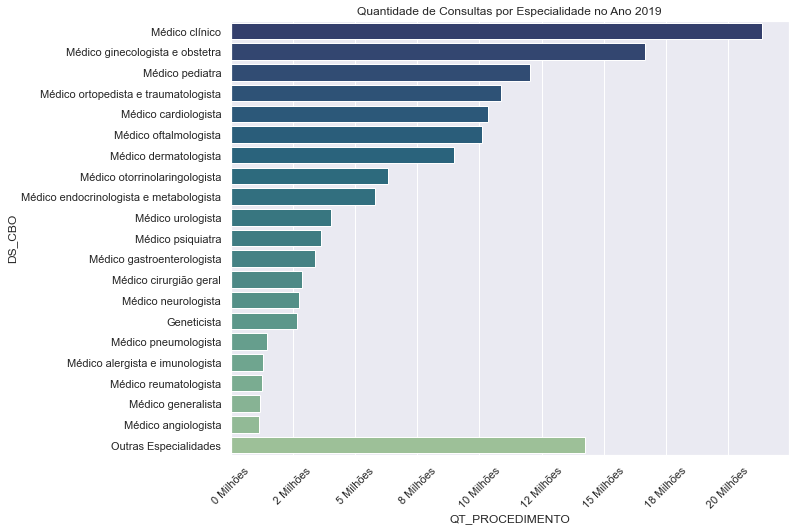

In [20]:
#Por curiosidade, vamos examinar melhor as especialidades
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Montando DF das especialidades "geral_DSCBO"
geral_DSCBO = df_geral.pivot_table(index='DS_CBO', values='QT_PROCEDIMENTO', aggfunc=np.sum)
geral_DSCBO = pd.DataFrame(geral_DSCBO.to_records())
geral_DSCBO = geral_DSCBO.sort_values(by='QT_PROCEDIMENTO', ascending=False)

#Ajustanto DF
N_rank = 20 #Quantidade de especialidades a serem exibidas
df_outros = pd.DataFrame({"QT_PROCEDIMENTO" : np.sum(geral_DSCBO["QT_PROCEDIMENTO"][N_rank:]),
                          "DS_CBO" : ["Outras Especialidades"]})
geral_DSCBO = pd.concat([geral_DSCBO[:N_rank], df_outros])

#Configurando o grafico
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
ax = sns.barplot(data=geral_DSCBO, x="QT_PROCEDIMENTO", y="DS_CBO", ci=None, palette="crest_r")#hue= "SEXO_BENEFICIARIO"
xlabels = ['{:,.0f}'.format(x) + ' Milhões' for x in ax.get_xticks()/1000000]
ax.set_xticklabels(xlabels, rotation=45)
ax.axes.set_title("Quantidade de Consultas por Especialidade no Ano 2019")
print(ax)




In [21]:
#Exibir a tabela com os dados
geral_DSCBO.index = np.arange(1, len(geral_DSCBO)+1)
geral_total = np.sum(geral_DSCBO['QT_PROCEDIMENTO'])
geral_DSCBO['%'] = geral_DSCBO['QT_PROCEDIMENTO'] / geral_total * 100
geral_DSCBO = geral_DSCBO.style.format({'%': "{:.2f}"})

geral_DSCBO

,DS_CBO,QT_PROCEDIMENTO,%
1,Médico clínico,21366902.990000,15.02
2,Médico ginecologista e obstetra,16645597.600000,11.70
3,Médico pediatra,12042040.700000,8.46
4,Médico ortopedista e traumatologista,10879302.260000,7.65
5,Médico cardiologista,10348824.000000,7.27
6,Médico oftalmologista,10093344.800000,7.09
7,Médico dermatologista,8984556.200000,6.31
8,Médico otorrinolaringologista,6304971.300000,4.43
9,Médico endocrinologista e metabologista,5786257.700000,4.07
10,Médico urologista,4019575.600000,2.82


Esse é o top 20 especialidades médicas. **Médico clínico** é o CBO que mais possui consultas.

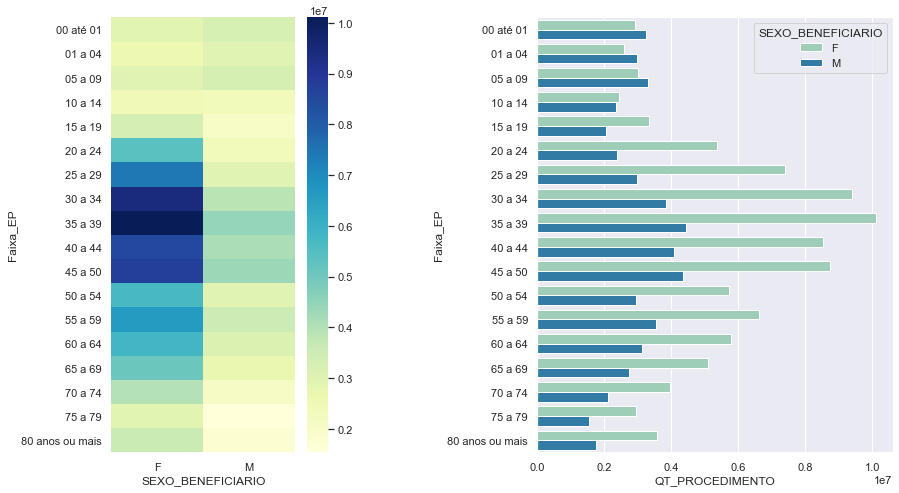

In [23]:
#Examinando as quantidades de consultas brutas após limpesa
pivot = pd.pivot_table(df_geral, values='QT_PROCEDIMENTO', index=['SEXO_BENEFICIARIO', 'Faixa_EP'],
                        aggfunc = np.sum) #Agrega as quantidades por Sexo e Faixa_EP
resumo = pd.DataFrame(pivot.to_records()) #Volta para formato DF

#Figuras
plt.figure(figsize=(14, 8))
#HeatMap
resumo_pivot = resumo.pivot('Faixa_EP','SEXO_BENEFICIARIO', 'QT_PROCEDIMENTO')
ax_heatmap = plt.subplot(1,3,1)
ax_heatmap = sns.heatmap(resumo_pivot, annot=False, fmt=".4f", cmap='YlGnBu') #cmap='crest_r'

#BarPlot
ax_bar = plt.subplot(1,2,2)
ax_bar = sns.barplot(data=resumo, 
                     x="QT_PROCEDIMENTO", 
                     y="Faixa_EP", 
                     ci=None,
                     hue= "SEXO_BENEFICIARIO",
                     palette="YlGnBu")#hue= "SEXO_BENEFICIARIO", palette="crest_r"

#print(ax_heatmap)
#print(ax_bar)
df_resumo = resumo_pivot.reset_index()
#df_resumo

In [24]:
#Carregando a tabela da ANS de beneficiários ativos em 201912
df_benef = pd.read_excel('Beneficiários por UFs, Regiões Metropolitanas (RM) e Capitais.xlsx')
df_benef

,Faixa etária,Masculino,Feminino,Total
0,TOTAL,22018711,25042374,47061085
1,00 até 01,330081,314458,644539
2,01 a 04,1460035,1379343,2839378
3,05 a 09,1619123,1532261,3151384
4,10 a 14,1362535,1305311,2667846
5,15 a 19,1245180,1268310,2513490
6,20 a 24,1502232,1634453,3136685
7,25 a 29,1710320,2029065,3739385
8,30 a 34,2121383,2496359,4617742
9,35 a 39,2270280,2597156,4867436


In [25]:
#Unindo a quantidade de beneficiários com a quantidade de consultas
df_resumo.rename({'Faixa_EP': 'Faixa etária', 
                  'F': 'Consultas_F',
                  'M' : 'Consutas_M'},
                 axis=1, inplace=True)
df_total = pd.merge(df_resumo, df_benef, on=['Faixa etária'])

#Ajustando os detalhes do df_total
df_total['Consulta_Total'] = df_total['Consultas_F'] + df_total['Consutas_M']
df_total.rename({'Feminino': 'Benef_F', 
                'Masculino': 'Benef_M',
                'Total': 'Benef_Total'},
                axis=1, inplace=True)
df_total['Cons/Benef_Total'] = df_total['Consulta_Total'] / df_total['Benef_Total']
df_total['Cons/Benef_F'] = df_total['Consultas_F'] / df_total['Benef_F']
df_total['Cons/Benef_M'] = df_total['Consutas_M'] / df_total['Benef_M']

df_total

,Faixa etária,Consultas_F,Consutas_M,Benef_M,Benef_F,Benef_Total,Consulta_Total,Cons/Benef_Total,Cons/Benef_F,Cons/Benef_M
0,00 até 01,2929668.47,3256399.61,330081,314458,644539,6186068.08,9.597663,9.316565,9.865456
1,01 a 04,2586387.11,2983814.38,1460035,1379343,2839378,5570201.49,1.961768,1.875086,2.043659
2,05 a 09,3007960.29,3290270.39,1619123,1532261,3151384,6298230.68,1.998560,1.963086,2.032131
3,10 a 14,2424615.54,2347699.29,1362535,1305311,2667846,4772314.83,1.788827,1.857500,1.723038
4,15 a 19,3323005.65,2045803.59,1245180,1268310,2513490,5368809.24,2.135998,2.620026,1.642978
5,20 a 24,5368665.08,2388091.38,1502232,1634453,3136685,7756756.46,2.472915,3.284686,1.589695
6,25 a 29,7395173.28,2975553.98,1710320,2029065,3739385,10370727.26,2.773378,3.644621,1.739764
7,30 a 34,9410502.31,3850519.47,2121383,2496359,4617742,13261021.78,2.871755,3.769691,1.815099
8,35 a 39,10106177.23,4433926.15,2270280,2597156,4867436,14540103.38,2.987220,3.891248,1.953031
9,40 a 44,8521997.61,4082907.87,1891405,2119293,4010698,12604905.48,3.142821,4.021151,2.158664


AxesSubplot(0.125,0.125;0.775x0.755)


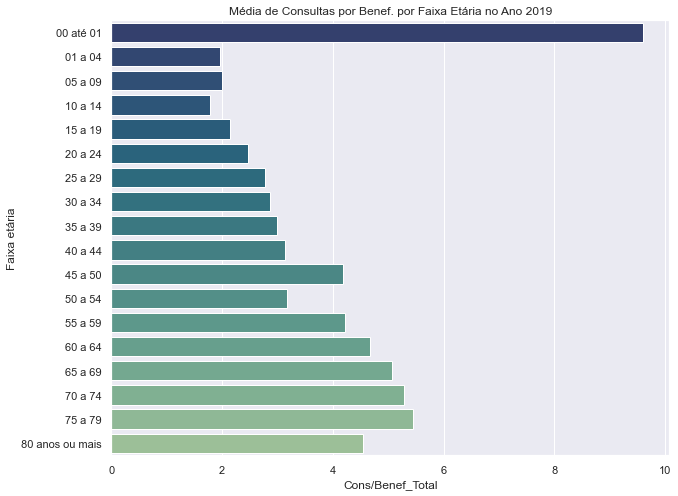

In [26]:
#Analizando a quantidade de consultas por faixa etária
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=df_total, x="Cons/Benef_Total", y="Faixa etária", ci=None, palette="crest_r")
ax.axes.set_title("Média de Consultas por Benef. por Faixa Etária no Ano 2019")
print(ax)

C:\Users\derec\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\derec\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:title={'center':'Quantidade de Consultas Realizadas por Beneficiário no Ano 2019'}, xlabel='Sexo', ylabel='Faixa Etária'>

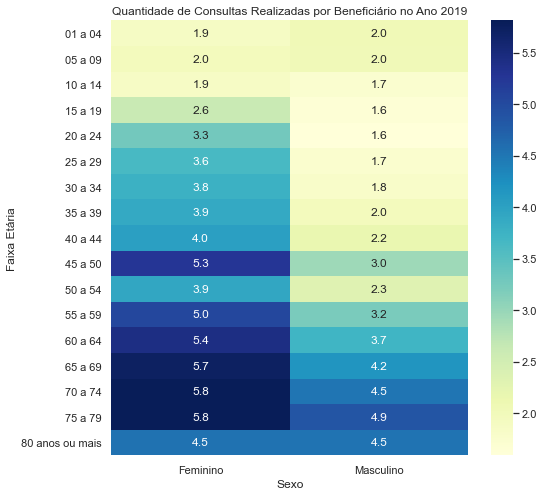

In [36]:
#Analizando a quantidade relativa de consultas por faixa etária
df_analise = df_total.loc[1:] #df_total['Faixa etária']!='00 até 01'
df_analise['F']='Feminino'
df_analise['M']='Masculino'
df_cons_relativa = pd.DataFrame({'Faixa Etária': pd.concat([df_analise['Faixa etária'], df_analise['Faixa etária']]),
                                 'Sexo': pd.concat([df_analise['F'], df_analise['M']]),
                                 'Cons/Benef':pd.concat([df_analise['Cons/Benef_F'], df_analise['Cons/Benef_M']])})


df_cons_relativa_pivot = df_cons_relativa.pivot('Faixa Etária','Sexo', 'Cons/Benef')

#Plotando 
plt.figure(figsize=(8, 8))
ax_heatmap = sns.heatmap(df_cons_relativa_pivot, annot=True, fmt=".1f", cmap='YlGnBu')
ax_heatmap.axes.set_title("Quantidade de Consultas Realizadas por Beneficiário no Ano 2019")
ax_heatmap

## Conclusão
Homens realmente vão mais ao médico quando mais velhos, mas comparando com as mulheres, elas fazem mais consultas em praticamente todas as faixas etárias. Por esse levantamento, é seguro afirmar que mulheres vão mais ao médico, não importa a idade.

**Em fim** <br>
Aí está, 648 arquivos, 125Gb de csv's, centenas de milhares de linhas resumidas em um gráfico belo e informativo. Muitas outras análises podem ser feitas a partir desse levantamento, por exemplo: E se desconsiderarmos Ginicologista e Obstetra, será que em alguma faixa os homens superam as mulheres? Muitas outras perguntas podem ser respondidas... Por enquanto encerro aqui.

Abraço.
